# 1. Reading kmer presence/absence matrix which will be used as input to the model

In [2]:
import os
import pandas as pd

os.chdir('..')

# Reading the kmer presence/absence matrix into a dataframe to use as input to models
df = pd.read_csv('/Data/Matrices/FullGeneKmerMatrix.csv', index_col=0)

# Checking that dataframe was read correctly
print(df.head())

        AAAACAACGCTAATCAAGCGAACAATCAAGC  AAACAACGCTAATCAAGCGAACAATCAAGCA  \
CA_001                              0.0                              0.0   
CA_002                              0.0                              0.0   
CA_003                              0.0                              0.0   
CA_005                              0.0                              0.0   
CA_007                              0.0                              0.0   

        AAATTATTAAAGTTTAAAGAATAACCACCAT  AAAGATTTTTGTAGTTCTTCATCTTGGTTAA  \
CA_001                              0.0                              0.0   
CA_002                              0.0                              0.0   
CA_003                              0.0                              0.0   
CA_005                              0.0                              0.0   
CA_007                              0.0                              0.0   

        AACAACGCTAATCAAGCGAACAATCAAGCAC  AACCAAGATGAAGAACTACAAAAATCTTTAG  \
CA_001    

# 2. Train/Test split with stratification

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

train_df, test_df = train_test_split(df, train_size=0.8, test_size=0.2, random_state=0, stratify=df.loc[:,'Label'])
train_labels = train_df.loc[:,'Label']
test_labels = test_df.loc[:,'Label']

print('Number of samples within each class:\t\t\t\t\t ' , np.unique(df.loc[:,'Label'], return_counts=True))
print('Number of samples within each class in training dataframe (stratified):\t ' , np.unique(train_df.loc[:,'Label'], return_counts=True))
print('Number of samples within each class in testing dataframe (stratified):\t ', np.unique(test_df.loc[:,'Label'], return_counts=True))

# Dropping the labels of both the train and test dataframes after storing them in separate series above (train_labels, test_labels)
train_df = train_df.drop(labels='Label', axis=1)
test_df = test_df.drop(labels='Label', axis=1)

Number of samples within each class:					  (array([0, 1], dtype=int64), array([28, 92], dtype=int64))
Number of samples within each class in training dataframe (stratified):	  (array([0, 1], dtype=int64), array([22, 74], dtype=int64))
Number of samples within each class in testing dataframe (stratified):	  (array([0, 1], dtype=int64), array([ 6, 18], dtype=int64))


# 3. Building RandomForest classifier using default parameters to determine baseline accuracy.
Default parameters:
- n_estimators=100
- criterion='gini'
- max_depth=None
- min_samples_split=2
- min_samples_leaf=1

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Initiailzing RandomForest classifier using default parameters
baseline_rf = RandomForestClassifier(random_state=0)

# Determining baseline accuracy and F1 score
baseline_accuracy = cross_val_score(baseline_rf, train_df, train_labels, cv=5, scoring='accuracy')
baseline_f1 = cross_val_score(baseline_rf, train_df, train_labels, cv=5, scoring='f1_weighted')

print('Baseline accuracy using default parameters: ')
print(baseline_accuracy)
print('Mean baseline accuracy:', baseline_accuracy.mean())

print('\nBaseline F1 score using default parameters: ')
print(baseline_f1)
print('Mean baseline F1 score:', baseline_f1.mean())

Baseline accuracy using default parameters: 
[0.65       0.73684211 0.63157895 0.84210526 0.73684211]
Mean baseline accuracy: 0.7194736842105264

Baseline F1 score using default parameters: 
[0.63620072 0.72675943 0.6456947  0.80191388 0.66985646]
Mean baseline F1 score: 0.6960850351178787


# 4. Hyperparameter tuning using GridSearchCV


### 4.1 Without balancing class weights

In [6]:
# Setting grid search parameters for tuning
param_grid = {
    'n_estimators': range(100, 1100, 100),
    'max_depth': range(10, 110, 10),
    'min_samples_leaf': range(1, 51, 1),

}

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV

# Performing grid search to tune hyperparameters specified in param_dict
grid_search = GridSearchCV(baseline_rf, param_grid, cv=5, scoring='accuracy', n_jobs=36)
grid_search.fit(train_df, train_labels)

# Determining the best parameters
grid_results_df=pd.DataFrame(grid_search.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
best_params_grid = grid_search.best_params_
best_model_grid = grid_search.best_estimator_

print("\nBest parameter combination using grid search:", best_params_grid)
print("\nThis combination has accuracy:\n", grid_results_df[grid_results_df['params'] == best_params_grid])

# Determining accuracy and F1 score of the model with the most tuned hyperparameters from grid search
cv_accuracy_tuned_model_grid = cross_val_score(best_model_grid, train_df, train_labels, cv=5, scoring='accuracy')
cv_f1_tuned_model_grid = cross_val_score(best_model_grid, train_df, train_labels, cv=5, scoring='f1_weighted')
cv_roc_auc_tuned_model_grid = cross_val_score(best_model_grid, train_df, train_labels, cv=5, scoring='roc_auc')

print('\nTuned RandomForest accuracy: ')
print(cv_accuracy_tuned_model_grid)
print('Mean tuned RandomForest accuracy:', cv_accuracy_tuned_model_grid.mean())

print('\nTuned RandomForest F1 score: ')
print(cv_f1_tuned_model_grid)
print('Mean tuned RandomForest F1 score:', cv_f1_tuned_model_grid.mean())

print('\nTuned RandomForest ROC AUC score: ')
print(cv_roc_auc_tuned_model_grid)
print('Mean tuned RandomForest ROC AUC score:', cv_roc_auc_tuned_model_grid.mean())


Best parameter combination using grid search: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}

This combination has accuracy:
     mean_test_score  std_test_score  \
11         0.781579        0.049653   

                                               params  
11  {'max_depth': 10, 'min_samples_leaf': 2, 'n_es...  

Tuned RandomForest accuracy: 
[0.75       0.84210526 0.73684211 0.84210526 0.73684211]
Mean tuned RandomForest accuracy: 0.781578947368421

Tuned RandomForest F1 score: 
[0.64285714 0.81591074 0.66985646 0.80191388 0.66985646]
Mean tuned RandomForest F1 score: 0.7200789363437919

Tuned RandomForest ROC AUC score: 
[0.36       0.55714286 0.38333333 0.71666667 0.41666667]
Mean tuned RandomForest ROC AUC score: 0.4867619047619047


### 4.2 With balancing class weights

In [10]:
# Setting grid search parameters for tuning
param_grid_balanced = {
    'n_estimators': range(100, 1100, 100),
    'max_depth': range(10, 110, 10),
    'min_samples_leaf': range(1, 11, 1),
    'class_weight': ['balanced', 'balanced_subsample']
}

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV

# Performing grid search to tune hyperparameters specified in param_dict
grid_search_balanced = GridSearchCV(baseline_rf, param_grid_balanced, cv=5, scoring='accuracy', n_jobs=36, verbose=3)
grid_search_balanced.fit(train_df, train_labels)

# Determining the best parameters
grid_results_balanced_df=pd.DataFrame(grid_search_balanced.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
best_params_balanced_grid = grid_search_balanced.best_params_
best_model_balanced_grid = grid_search_balanced.best_estimator_

print("\nBest parameter combination using grid search:", best_params_balanced_grid)
print("\nThis combination has accuracy:\n", grid_results_balanced_df[grid_results_balanced_df['params'] == best_params_balanced_grid])

# Determining accuracy and F1 score of the model with the most tuned hyperparameters from grid search
cv_accuracy_tuned_balanced_model_grid = cross_val_score(best_model_balanced_grid, train_df, train_labels, cv=5, scoring='accuracy')
cv_f1_tuned_balanced_model_grid = cross_val_score(best_model_balanced_grid, train_df, train_labels, cv=5, scoring='f1_weighted')
cv_roc_auc_tuned_balanced_model_grid = cross_val_score(best_model_balanced_grid, train_df, train_labels, cv=5, scoring='roc_auc')

print('\nTuned balanced RandomForest accuracy: ')
print(cv_accuracy_tuned_balanced_model_grid)
print('Mean tuned balanced RandomForest accuracy:', cv_accuracy_tuned_balanced_model_grid.mean())

print('\nTuned balanced RandomForest F1 score: ')
print(cv_f1_tuned_balanced_model_grid)
print('Mean tuned balanced RandomForest F1 score:', cv_f1_tuned_balanced_model_grid.mean())

print('\nTuned balanced RandomForest ROC AUC score: ')
print(cv_roc_auc_tuned_balanced_model_grid)
print('Mean tuned balanced RandomForest ROC AUC score:', cv_roc_auc_tuned_balanced_model_grid.mean())

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits

Best parameter combination using grid search: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 900}

This combination has accuracy:
     mean_test_score  std_test_score  \
18         0.728947        0.052368   

                                               params  
18  {'class_weight': 'balanced', 'max_depth': 10, ...  

Tuned balanced RandomForest accuracy: 
[0.75       0.73684211 0.63157895 0.78947368 0.73684211]
Mean tuned balanced RandomForest accuracy: 0.7289473684210527

Tuned balanced RandomForest F1 score: 
[0.70779221 0.72675943 0.61120543 0.76096491 0.66985646]
Mean tuned balanced RandomForest F1 score: 0.6953156879288254

Tuned balanced RandomForest ROC AUC score: 
[0.44       0.57142857 0.38333333 0.55       0.43333333]
Mean tuned balanced RandomForest ROC AUC score: 0.47561904761904755


# 5. Using the Optimized RF model on testing data to determine accuracy. This process is done once for RF model without class balancing and again for RF with class balancing.
- Classification report
- Confusion matrix


In [31]:
# For RF without class balancing

from sklearn.metrics import classification_report

RFmodel_predictions = best_model_grid.predict(test_df) 
  
print(classification_report(test_labels, RFmodel_predictions))

              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.78      1.00      0.88        18

    accuracy                           0.79        24
   macro avg       0.89      0.58      0.58        24
weighted avg       0.84      0.79      0.73        24



In [12]:
# For RF with class balancing

from sklearn.metrics import classification_report

RFmodel_predictions = best_model_balanced_grid.predict(test_df) 
  
print(classification_report(test_labels, RFmodel_predictions))

              precision    recall  f1-score   support

           0       0.33      0.17      0.22         6
           1       0.76      0.89      0.82        18

    accuracy                           0.71        24
   macro avg       0.55      0.53      0.52        24
weighted avg       0.65      0.71      0.67        24



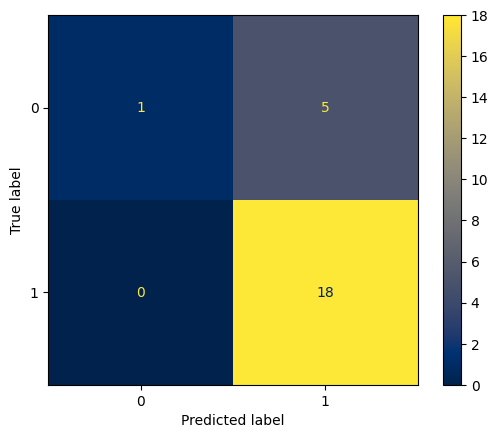

In [33]:
# For RF without class balancing

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

RFmodel_predictions = best_model_grid.predict(test_df) 

disp = ConfusionMatrixDisplay.from_predictions(test_labels, RFmodel_predictions, labels=best_model_grid.classes_, cmap='cividis')


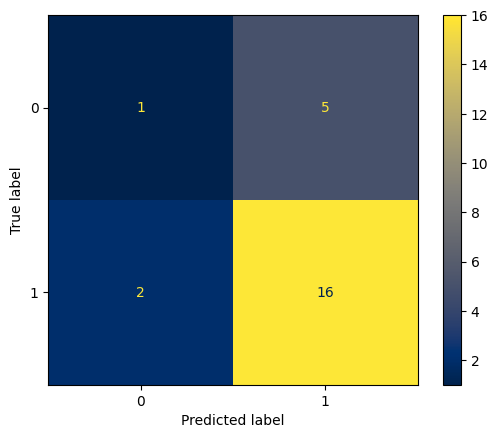

In [13]:
# For RF with class balancing

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

RFmodel_predictions = best_model_balanced_grid.predict(test_df) 

disp = ConfusionMatrixDisplay.from_predictions(test_labels, RFmodel_predictions, labels=best_model_balanced_grid.classes_, cmap='cividis')

# 6. Extracting the kmers used by RandomForest classifier according to feature importance
- Sorting the kmers by descending feature importance
- Extracting the kmers with nonzero feature importances only

This step is done as a type of feature selection method that identifies the most important kmers for classification. These specific kmers can then be used as input to another model instead of using the full kmer matrix which contained 22,435 kmers.

In [15]:
# Extract kmers used to build tree
rf_importances = best_model_grid.feature_importances_

# Save Kmers and their corresponding importance values in dataframe
rf_importances_df = pd.DataFrame({
    'Kmer': train_df.columns,
    'Importance': rf_importances
})

print('Matrix of Kmer importances for all kmers:\n', rf_importances_df.head())
print('Dimensions:', rf_importances_df.shape)

# Save Kmers and their corresponding importance values in dataframe
rf_importances_df = rf_importances_df.sort_values(by='Importance', ascending=False)
print('\nMatrix of Kmer importances sorted by descending importance:\n', rf_importances_df.head())
print('Dimensions:', rf_importances_df.shape)

nonzero_importances = rf_importances_df[rf_importances_df['Importance'] != 0]
print('\nMatrix of Kmer importances for kmers used in RF construction only (i.e. kmers with nonzero importance values only):\n', nonzero_importances.head())
print('Dimensions:', nonzero_importances.shape)

nonzero_importances.to_csv('Data/Matrices/ImportantKmers.csv', index=True)

Matrix of Kmer importances for all kmers:
                               Kmer  Importance
0  AAAACAACGCTAATCAAGCGAACAATCAAGC         0.0
1  AAACAACGCTAATCAAGCGAACAATCAAGCA         0.0
2  AAATTATTAAAGTTTAAAGAATAACCACCAT         0.0
3  AAAGATTTTTGTAGTTCTTCATCTTGGTTAA         0.0
4  AACAACGCTAATCAAGCGAACAATCAAGCAC         0.0
Dimensions: (22435, 2)

Matrix of Kmer importances sorted by descending importance:
                                   Kmer  Importance
17740  ACCAGTACCACCTGCCAAAGAAGAACCTAAA    0.009313
18028  ACAGCGATTCAGACTCAGATAGCGACTCAGA    0.007401
18481  TAACCAAGACGGAAAACGACCAACTGAAATC    0.006464
13648  AATTCAACTAAGTTAGACTCAGTAGTAACCT    0.006102
11165  AGTCGGAATCACTATCTGAATCCGAATCACT    0.004921
Dimensions: (22435, 2)

Matrix of Kmer importances for kmers used in RF construction only (i.e. kmers with nonzero importance values only):
                                   Kmer  Importance
17740  ACCAGTACCACCTGCCAAAGAAGAACCTAAA    0.009313
18028  ACAGCGATTCAGACTCAGATAGCGACTCAGA   